In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df=pd.read_csv('distance_matrix.csv', sep=',',header=None)
df1 = pd.read_csv('flows.csv', sep=',',header=None).fillna(0)
header = df1.iloc[0]
df1 = df1.iloc[1:79]
df1.columns = header
df1 = df1.drop(labels = ['iii', 'TAZ (8a)', 'iv'],axis = 1)
vec = df1
#df1 = df1.drop(labels = [header[0]],axis = 1)
df1

,Home to EDU and Work (Production) (i),Home to EDU and work (Attraction) (i),Work to Home (Production) (ii),Work to Home (Attraction) (ii),Home to shop Production,Home to Shop Attraction,Shop to Home Production,Shop to Home Attraction,EDU and work to Shop (Production),EDU and work to Shop (Attraction)
1,16758,0,0,14364,3591,0,0,3591,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,20001,16001,0,0,0,0,0,4000,0
5,18035,0,0,11172,2793,0,0,2793,0,0
...,...,...,...,...,...,...,...,...,...,...
74,0,0,0,0,0,2207,2207,0,0,2207
75,0,0,0,0,0,0,0,0,0,0
76,0,7385,5908,0,0,0,0,0,1477,0
77,0,0,0,0,0,0,0,0,0,0


In [2]:
df1.to_csv("flows_clean.csv")

In [3]:
#convert entire dataframe from strings to int64 types. Select P and A arrays by column.
vec = vec.apply(pd.to_numeric)
trip_arr = vec.to_numpy()
header.drop([0,5,10]).reset_index(drop = True)

0    Home to EDU and Work (Production) (i)
1    Home to EDU and work (Attraction) (i)
2           Work to Home (Production) (ii)
3           Work to Home (Attraction) (ii)
4                  Home to shop Production
5                  Home to Shop Attraction
6                  Shop to Home Production
7                  Shop to Home Attraction
8        EDU and work to Shop (Production)
9        EDU and work to Shop (Attraction)
Name: 0, dtype: object

In [4]:
#Set P and A Vectors using indicies printed above
P = trip_arr[:,0]
A = trip_arr[:,1]

In [5]:
DM = pd.DataFrame(df).to_numpy()

In [6]:
#distance matrix? with diagonals representing the average distance traveled to get to zone center
D = DM

In [7]:
# Gravity model - given A, we want A^* to be used so sum_i T_ij = A_j
# A_j is the total trip attraction at zone j
#P_i = total trip production at zone i
#T_ij is the trips produced at I and attracted to j
#F_ij is the calibration term for interchange ij also known as the friction factor or tracel time factor

dims = A.shape[0]
A = A.reshape(dims, 1)
P = P.reshape(dims, 1)

def calculate_T(A, P, D):
    # invert and square for disutility
    F = np.power(D,-2)
    T = np.zeros_like(D)
    
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            denom = F[i,:] @ A
            T[i,j] = P[i]*F[i,j]*A[j]/denom
    
    return T
    
def calculate_A_star(A, P, D):
    A_old = A.copy()
    C = np.ones_like(A)
    eps = 1e1
    n = A.shape[0]
    
    while (np.linalg.norm(C-A) > eps):
        T = calculate_T(A_old, P, D)
        C = T.sum(axis=0).reshape(n,1)
        
        for j in range(n):
            if C[j] != 0:
                A_old[j] = A[j]*A_old[j] / C[j]
        
    return A_old
    
A_star = calculate_A_star(A, P, D)
T = calculate_T(A_star, P, D)

print(T.sum(axis=0)) # should equal A
print(T.sum(axis=1)) # should equal P

[    0.             0.             0.         20001.12419788
     0.          3692.01142405     0.             0.
     0.             0.             0.             0.
     0.          5537.52379595     0.             0.
     0.             0.             0.             0.
     0.          5537.3604943   7385.20029178     0.
     0.             0.             0.          5537.80147453
     0.             0.             0.         59594.58235819
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.         59599.83740485     0.
     0.         52142.05311478     0.             0.
     0.             0.             0.             0.
     0.             0.          5538.56129077     0.
 52145.37029855  3691.94723548     0.             0.
     0.          9229.79911108     0.             0.
     0.             0.             0.          9229.43797842
     0.             0.          9230.70566259     0.
     0.       

In [8]:
print(T)
print(np.shape(T))
np.sum(T)

[[  0.           0.           0.         ...  22.92058275   0.
  350.34922769]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(78, 78)


375073.0

In [9]:
N = np.unravel_index(np.argsort(D.ravel()), np.shape(D))
print(N)

(array([64, 62, 16, ..., 11, 74,  8]), array([62, 64, 17, ..., 74,  8, 74]))


In [10]:
y = np.zeros(np.size(T))
y_dens = np.zeros(np.size(T))
x = np.zeros(np.size(T))
for i in range(np.size(T)):
    if i == 0:
        y[i] = T[N[0][i], N[1][i]]
    else:
        y[i] = y[i-1] + T[N[0][i], N[1][i]]
        y_dens[i] = T[N[0][i], N[1][i]]
    x[i] = D[N[0][i], N[1][i]]
print(y)
print(x)
    

[     0.      0.      0. ... 375073. 375073. 375073.]
[ 0.18294641  0.18294641  0.56568542 ... 22.24613028 23.14822482
 23.14822482]


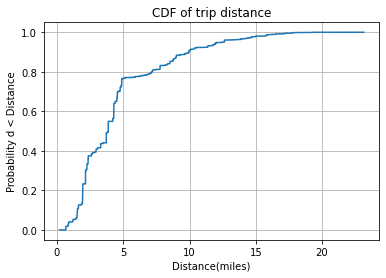

In [11]:
plt.plot(x,y/max(y))
plt.xlabel('Distance(miles)')
plt.ylabel('Probability d < Distance')
plt.title("CDF of trip distance")
plt.grid()

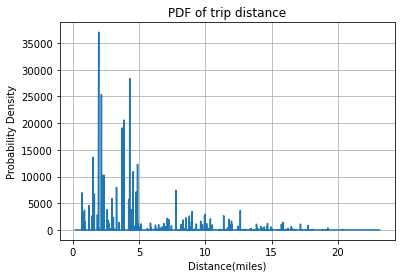

In [12]:
plt.plot(x,y_dens)
plt.xlabel('Distance(miles)')
plt.ylabel('Probability Density')
plt.title("PDF of trip distance")
plt.grid()

In [13]:

df2=pd.read_csv('problem8_tensorData - problem8_tensorData.csv', sep=',',header=None)
header_csv = df2.iloc[0]
df2.columns = header_csv
df2 = df2.iloc[1:79]
df2

,TAZ,Label,Pix_Count,X_Centroid,Y_Centroid,Var6
1,1,6,9,2.888888889,4.666666667,Residential
2,2,2,3,2,4,Greenland
3,3,3,1,2,7,Beach (leisure)
4,4,1,247,8.497975709,18.15789474,Seawater
5,5,6,7,2.285714286,21.42857143,Residential
...,...,...,...,...,...,...
74,74,8,3,28.33333333,19.33333333,Dispensaries
75,75,2,16,31.4375,7.0625,Greenland
76,76,5,4,30.5,15.5,K-12
77,77,2,6,31.83333333,16.66666667,Greenland


In [14]:
lat = np.linspace(37.67637961,37.90768039,num = 31)
lon = np.linspace(-122.5191224,-122.2878216, num = 31)
lat_step = (37.90768039-37.67637961) / 31.0
lon_step = (-122.2878216 - -122.5191224) / 31.0

In [15]:
#conversions
lats = pd.to_numeric(df2.iloc[:, 4])
lats = pd.Series(lats).to_numpy()-1
latitudes = 37.90768039 - (lats) * lat_step
lons = pd.to_numeric(df2.iloc[:, 3])
lons = pd.Series(lons).to_numpy()-1
longitudes = (lons) * lon_step + -122.5191224
print(lats)
print(lons)

[ 3.66666667  3.          6.         17.15789474 20.42857143 23.5
 25.66666667 27.75       31.          7.         29.         31.
 32.          2.          7.5         9.375       1.          1.66666667
  3.          3.          4.          7.         31.          1.
  3.4         7.5        27.          2.          5.         12.83333333
 21.          5.75       29.4        31.          2.2         7.
  5.         31.05882353 31.83333333  2.          2.21153846  6.
 28.75       24.         26.8         6.14285714  9.15384615 15.42857143
 20.5        25.67005076 13.95652174 26.5        18.33333333 28.5
 30.          2.61538461 16.57142857 12.5        19.          5.6
 18.          6.4        10.38095238 17.09677419 10.61904762  4.47058824
  5.88888889 15.2        20.88888889  3.          6.         10.5625
 14.63636364 18.33333333  6.0625     14.5        15.66666667 17.625     ]
[ 1.88888889  1.          1.          7.49797571  1.28571429  1.
  1.33333333  1.25        1.          2.  

In [16]:
coordinates = np.array([latitudes, longitudes])
np.shape(coordinates.T)
coord = pd.DataFrame(coordinates.T)
coord.to_csv("coords.csv")
coord



,0,1
0,37.880322,-122.505029
1,37.885296,-122.511661
2,37.862912,-122.511661
3,37.779660,-122.463178
4,37.755256,-122.509529
...,...,...
73,37.770890,-122.315180
74,37.862446,-122.292019
75,37.799491,-122.299014
76,37.790786,-122.289065
